In [1]:
!git clone "https://github.com/amanjaiswal73892/changemypet.git"

Cloning into 'changemypet'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 62 (delta 14), reused 27 (delta 1), pack-reused 0
Unpacking objects: 100% (62/62), done.


In [2]:
# Importing the weigths from google drive
"""Recommended to upload the downloaded biggan parameters in google drive"""
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import torch
from changemypet.src.biggan import BigGAN512
import torch 
import torchvision
from scipy.stats import truncnorm
from torch.autograd import Variable
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from torchvision import transforms

In [4]:
# Importing pretrained segmentation models from Pytorch Hub
model = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True).eval()
model2 = torch.hub.load('pytorch/vision:v0.6.0', 'fcn_resnet101', pretrained=True).eval()


Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth


In [7]:
"""Assigning the inputs of Biggan
Truncation(0.02-1) : Truncation value 
class(0-999) : The class of the generated image
z : noise vector 
"""

truncation = torch.clamp(torch.tensor(0.4), min=0.02+1e-4, max=1.0-1e-4).float()  # truncation is 0.4
c = torch.tensor((208,)).long()  # class_label is 260
z = truncation * torch.as_tensor(truncnorm.rvs(-2.0, 2.0, size=(1, 128),random_state=1)).float()

z.requires_grad = True

biggan = BigGAN512()

# Loading the 512X512 version of biggan 
biggan.load_state_dict(torch.load("/content/drive/My Drive/biggan/biggan512-release.pt"))

<All keys matched successfully>

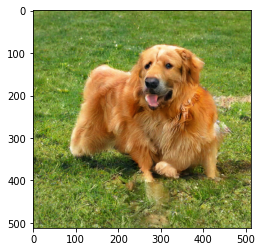

In [6]:
#Run this if you want a generated image to be the target image.
"""Saving a generated image to be used as target image"""
biggan.eval()

img = biggan(z, c, truncation.item())

# The ouputs need to normalised since the last layer of gan in TanH"
pil = torchvision.transforms.ToPILImage()((0.5 * (img.data + 1)).squeeze())

import PIL
"""Uncomment tranformations if required"""
# pil=ImageOps.mirror(pil)
# pil=pil.transpose(PIL.Image.ROTATE_90)
plt.imshow(pil)
"""Uncomment to save the image"""
pil.save("dog_translate.png")

In [8]:

"""Preprocessing required for segmentation models"""
# Input the path of teh target image
path = '/content/dog_translate.png'
input_image = Image.open(path)
preprocess = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)

# create a mini-batch as expected by the model
input_batch = input_tensor.unsqueeze(0)

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')
    model2.to('cuda')


In [9]:
# Soft-cross entropy loss
def softXEnt (input, target ):
    logprobs = torch.nn.functional.log_softmax (input, dim = 0)
    return  -(target * logprobs).sum() / (input.shape[1]*input.shape[2])  


# Used for creating gifs
"""These functions are used for concatenating two images horizontally or vertically"""
def get_concat_h(im1, im2):
  # max is used for Asymmetric images
    dst_h = Image.new('RGB', (im1.width + im2.width, max(im1.height,im2.height)))
    dst_h.paste(im1, (0, 0))
    dst_h.paste(im2, (im1.width, 0))
    return dst_h

def get_concat_v(im1, im2):
    dst_v = Image.new('RGB', (max(im1.width,im2.width), im1.height + im2.height))
    dst_v.paste(im1, (0, 0))
    dst_v.paste(im2, (0, im1.height))
    return dst_v


# create a color pallette, selecting a color for each class

palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# mean and std required for preprocessing in segmentation model

mean1 = [0.485, 0.456, 0.406]
std1 = [0.229, 0.224, 0.225]


Epoch :  1
Loss  :  0.06557002663612366


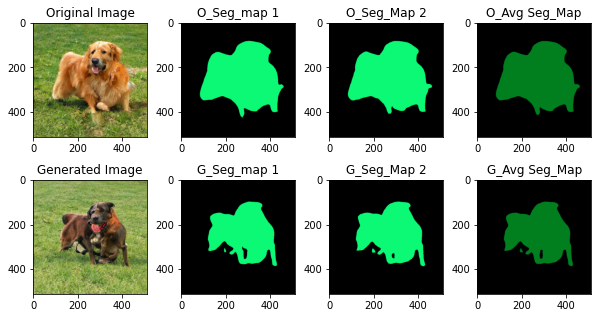

----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.py:127: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output contiguous tensor even if some of the inputs are in channels_last format. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorIterator.cpp:918.)
  allow_unreachable=True)  # allow_unreachable flag
/usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.py:127: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output channels_last tensor even if some of the inputs are not in channels_last format. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorIterator.cpp:924.)
  allow_unreachable=True)  # allow_unreachable flag


Epoch :  2
Loss  :  0.054564110934734344


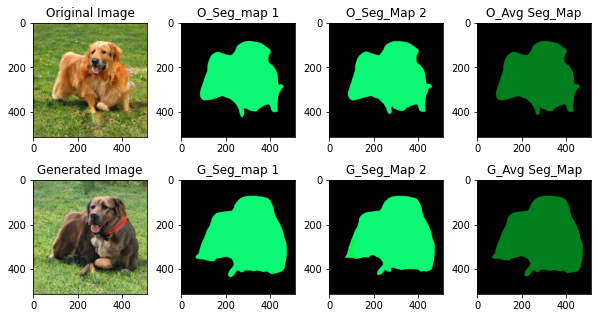

----------------------------------------------------------------------------------------------------
Epoch :  3
Loss  :  0.04682553559541702


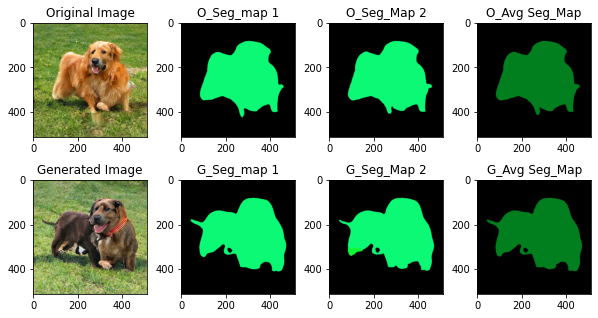

----------------------------------------------------------------------------------------------------
Epoch :  4
Loss  :  0.03800398111343384


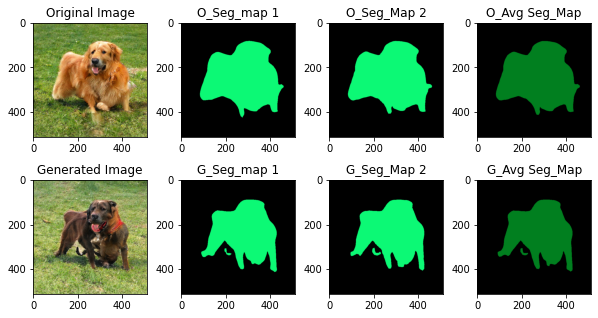

----------------------------------------------------------------------------------------------------
Epoch :  5
Loss  :  0.04001881927251816


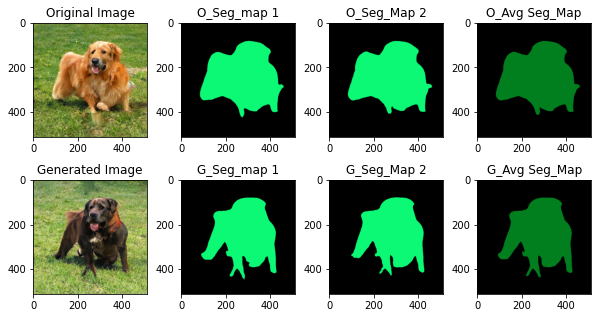

----------------------------------------------------------------------------------------------------
Epoch :  6
Loss  :  0.021177351474761963


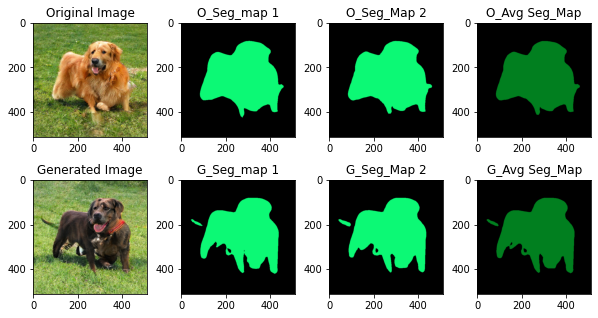

----------------------------------------------------------------------------------------------------
Epoch :  7
Loss  :  0.015682723373174667


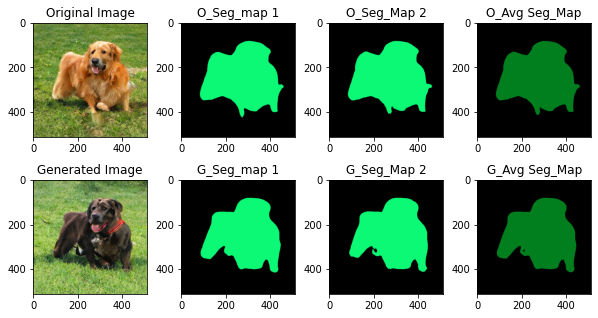

----------------------------------------------------------------------------------------------------
Epoch :  8
Loss  :  0.010487130843102932


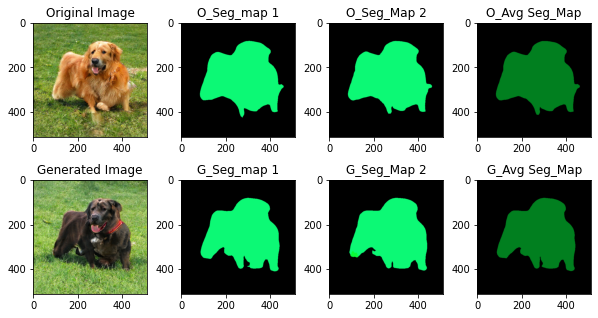

----------------------------------------------------------------------------------------------------
Epoch :  9
Loss  :  0.014311944134533405


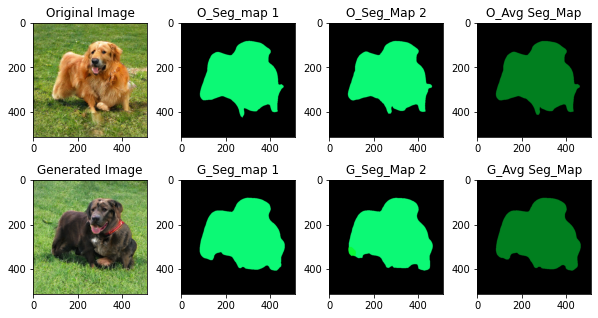

----------------------------------------------------------------------------------------------------
Epoch :  10
Loss  :  0.0322190560400486


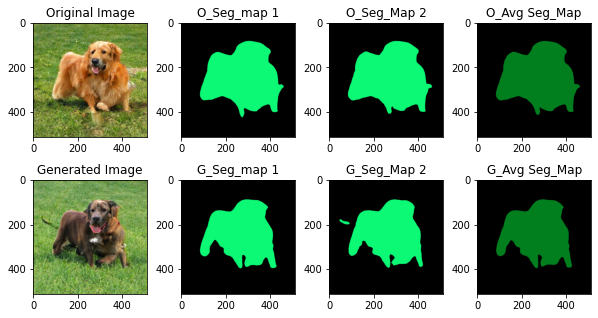

----------------------------------------------------------------------------------------------------
Epoch :  11
Loss  :  0.03883061185479164


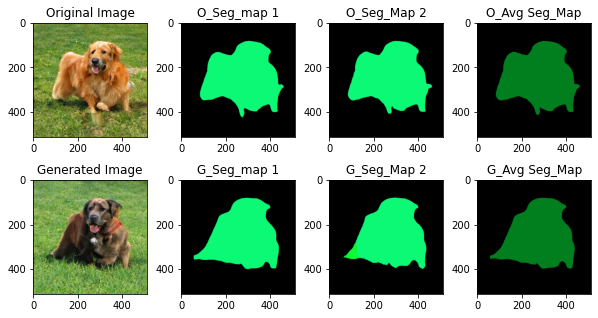

----------------------------------------------------------------------------------------------------
Epoch :  12
Loss  :  0.05355124548077583


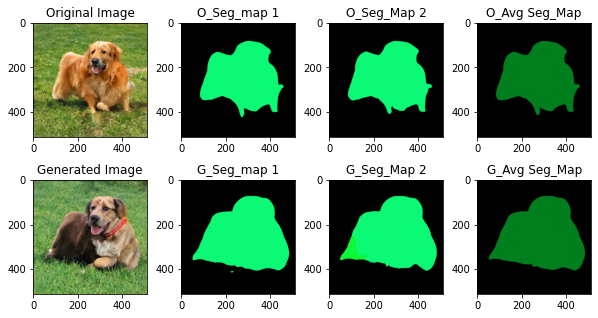

----------------------------------------------------------------------------------------------------
Epoch :  13
Loss  :  0.026156913489103317


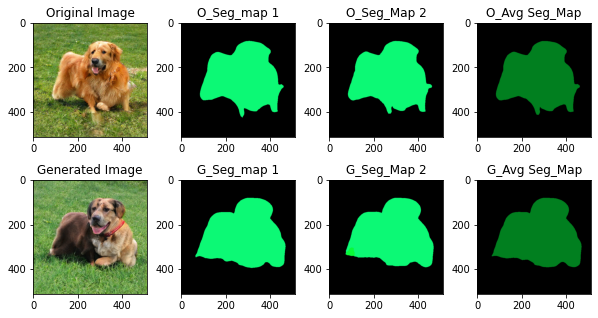

----------------------------------------------------------------------------------------------------
Epoch :  14
Loss  :  0.01644825004041195


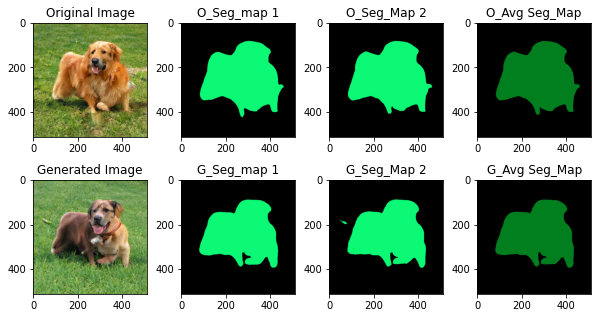

----------------------------------------------------------------------------------------------------
Epoch :  15
Loss  :  0.010378751903772354


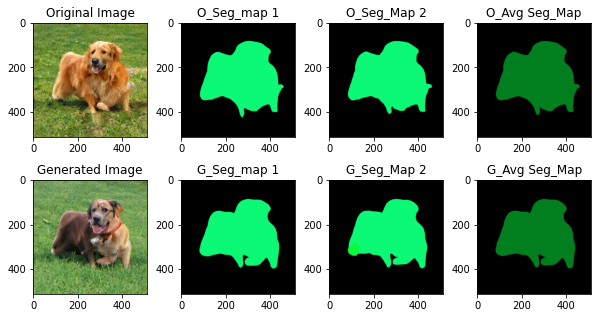

----------------------------------------------------------------------------------------------------
Epoch :  16
Loss  :  0.02125130407512188


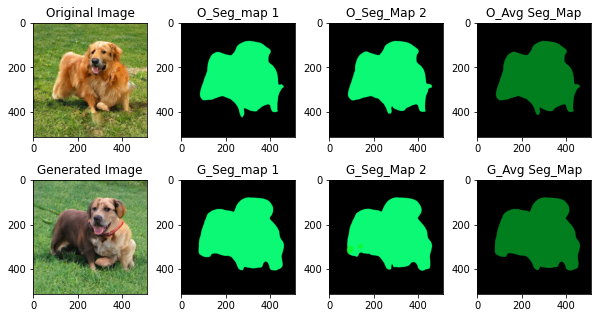

----------------------------------------------------------------------------------------------------
Epoch :  17
Loss  :  0.011629241518676281


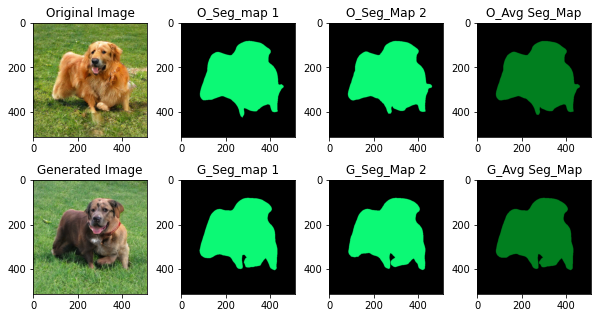

----------------------------------------------------------------------------------------------------
Epoch :  18
Loss  :  0.015902435407042503


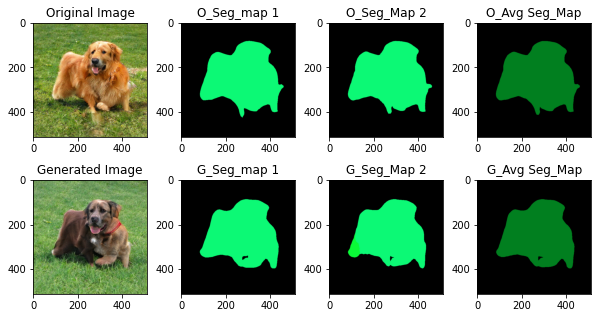

----------------------------------------------------------------------------------------------------
Epoch :  19
Loss  :  0.020012512803077698


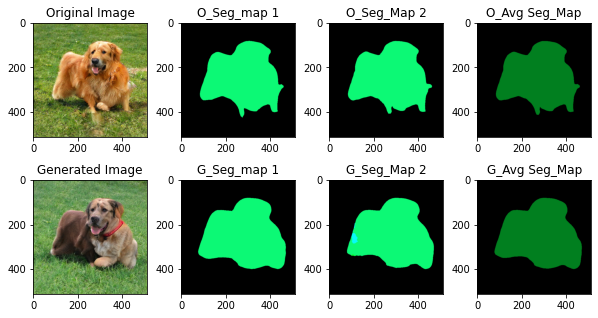

----------------------------------------------------------------------------------------------------
Epoch :  20
Loss  :  0.00734387943521142


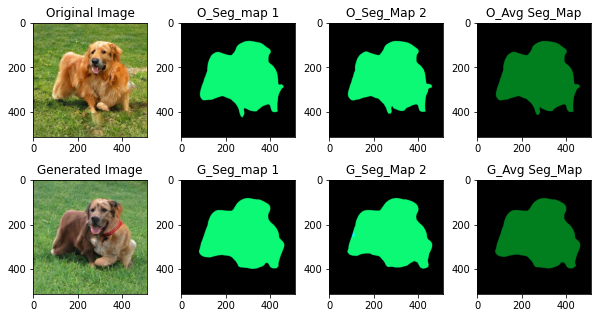

----------------------------------------------------------------------------------------------------
End


In [10]:

gif = [] # list of frames in gifs

biggan.eval()
optimizer = torch.optim.Adam([z], lr=1e-1, betas=(0.5, 0.999))

for i in range(20):
    with torch.enable_grad():
        optimizer.zero_grad()
        img = biggan(z, c, truncation.item())
        # preprocessing of the generated image for segmentation model
        img1 = 0.5 * (img + 1)
        img1[0][0] = (img1[0][0] - mean1[0])/std1[0]
        img1[0][1] = (img1[0][1] - mean1[1])/std1[1]
        img1[0][2] = (img1[0][2] - mean1[2])/std1[2]
        
        #Segmentation of Predicted Img (Generated image)
        output_predicted_image_1 = model(0.5 * (img.cuda() + 1))['out'][0]
        output_predicted_image_2 = model2(0.5 * (img.cuda() + 1))['out'][0]
        
        #Applying softmax on predicted imgs seg_maps
        output_predicted_image_1_s = torch.nn.functional.softmax (output_predicted_image_1, dim = 0) 
        output_predicted_image_2_s = torch.nn.functional.softmax (output_predicted_image_2, dim = 0) 
        
        # Average of 2 predicted img seg_maps
        output_p = (output_predicted_image_1_s * 0.6) + (output_predicted_image_2_s * 0.4)  
        
        # Segmentation of Original Img
        output_original_image_1 = model(input_batch)['out'][0]
        output_original_image_2 = model2(input_batch)['out'][0]
        
        # applying softmax on original imgs segmaps
        output_original_image_1_s = torch.nn.functional.softmax (output_original_image_1, dim = 0) 
        output_original_image_2_s = torch.nn.functional.softmax (output_original_image_2, dim = 0) 
        
        # Average of Two original(target) img seg_maps
        output_o = (output_original_image_1_s + output_original_image_2_s)/2

        # MSE_loss computed on "dog":= 12 channel 
        target = output_o[12]
        pred = output_p[12]
        loss = torch.nn.MSELoss()
        cost_x = loss(pred,target)
        print("Epoch : ",i+1)
        print("Loss  : ", cost_x.item())

    #Used for visualization and gifs
    fig = plt.figure(figsize=(10,5))
    plt.subplots_adjust(left = 0.125,right = 0.9,top=0.9,bottom = 0.1,wspace = 0.3,hspace = 0.2)

    ax1 = fig.add_subplot(241)
    ax1.title.set_text('Original Image')
    plt.imshow(input_image)

    ax2 = fig.add_subplot(242)
    ax2.title.set_text('O_Seg_map 1')
    r = Image.fromarray(model(input_batch)['out'][0].argmax(0).float().byte().cpu().numpy())#.resize(input_image.size)
    r.putpalette(colors)
    plt.imshow(r)
     
    ax3 = fig.add_subplot(243)
    ax3.title.set_text('O_Seg_Map 2')
    r = Image.fromarray(model2(input_batch)['out'][0].argmax(0).float().byte().cpu().numpy())#.resize(input_image.size)
    r.putpalette(colors)
    plt.imshow(r)

    ax4 = fig.add_subplot(244)
    ax4.title.set_text('O_Avg Seg_Map')
    seg_map_o = Image.fromarray(output_o[[0,12]].argmax(0).float().byte().cpu().numpy())
    seg_map_o.putpalette(colors)
    plt.imshow(seg_map_o)

    

    ax5 = fig.add_subplot(245)
    ax5.title.set_text('Generated Image')
    pil_gen = torchvision.transforms.ToPILImage()((0.5 * (img.data + 1)).squeeze())
    plt.imshow(pil_gen)

    ax6 = fig.add_subplot(246)
    ax6.title.set_text('G_Seg_map 1')
    r = Image.fromarray(output_predicted_image_1.argmax(0).float().byte().cpu().numpy())
    r.putpalette(colors)
    plt.imshow(r)

    ax7 = fig.add_subplot(247)
    ax7.title.set_text('G_Seg_Map 2')
    r = Image.fromarray(output_predicted_image_2.argmax(0).float().byte().cpu().numpy())
    r.putpalette(colors)
    plt.imshow(r)

 
    ax8 = fig.add_subplot(248)
    ax8.title.set_text('G_Avg Seg_Map')
    seg_map_gen = Image.fromarray(output_p[[0,12]].argmax(0).float().byte().cpu().numpy())
    seg_map_gen.putpalette(colors)
    plt.imshow(seg_map_gen)

    #concatenating images horizontally and vertically for the final gif frame. 
    hz_1 = get_concat_h(input_image,pil_gen)
    hz_2 = get_concat_h(seg_map_o,seg_map_gen)
    v = get_concat_v(hz_1,hz_2)
    gif.append(v)
    plt.show()

    print('-'*100)
    cost_x.backward()
    optimizer.step()

print('End')

In [ ]:
# Creating a full size gif 
gif[0].save('out1.gif', save_all=True, append_images=gif[1:],optimize=False, duration=150, loop=0)

In [ ]:
# Creating a smaller size gif , useful for if generated images are 512x512
gif_2 = []
for x in gif:
  im = x
  (width, height) = (im.width // 2, im.height // 2)
  im_resized = im.resize((width, height))
  gif_2.append(im_resized)
gif_2[0].save('out_resized_1.gif', save_all=True, append_images=gif_2,optimize=False, duration=250, loop=0)